In [183]:
# Imports and option settings

import altair as alt
import pandas as pd
import numpy as np
import os
import warnings

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold

alt.renderers.enable('notebook')
alt.data_transformers.enable('default', max_rows = None)
warnings.filterwarnings('ignore')

glovogreen = 'rgb(0,162,138)'
glovoyellow = 'rgb(252,224,93)'

In [184]:
# Define a few functions used later on in the notebook

def normalize_column(df, column):
    return (df[column] - min(df[column])) / (max(df[column]) - min(df[column]))

def get_perc(df, group, column):
    frequency = df.groupby(group).agg({column: 'value_counts'})
    frequency.columns = [column + '_frequency']
    frequency.reset_index(drop = False, inplace = True)
    
    sizes = df.groupby(group).size()
    
    frequency.loc[frequency[group] == 0, column + '_rel'] = frequency[column + '_frequency'] / sizes.loc[0]
    frequency.loc[frequency[group] == 1, column + '_rel'] = frequency[column + '_frequency'] / sizes.loc[1]
    
    return frequency   

## Technical test results, Glovo, Senior Data Scientist
### Author: Julian Hohlweg

### My understanding of the task:
    
* Build a churn (for the lack of a better term) prediction model for couriers using weekly and lifetime courier data
* Courier churn is defined as a courier not having weekly data for week 9, 10 and 11 (he may have data for some of those weeks but not all)
* The churn model should make its predictions 2 weeks prior to churn. For this reason, the weekly data used for exploration and modeling shall be restricted to week 0 to week 7
* There are many couriers in the lifetime data set who do not have any corresponding entries in the weekly data set. I assume there is no prediction required for these couriers
* I also exclude couriers who do not have any entries for week 0 to 7 (there are about 30 of those)
* The decisions taken above may or may not be target-aimed depending on the business case behind the task

In [185]:
# Load data

files = os.listdir("/Users/julian/desktop/glovo")
csvs = [file for file in files if file.endswith(".csv")]

weekly = pd.read_csv(csvs[0])
lifetime = pd.read_csv(csvs[1])

In [186]:
# Create dataframe which will hold labels and engineered features on courier level for the modeling later on

couriers = pd.DataFrame(columns = ["label"])

# Label every courier present in weekly data set based on whether data on week 9, 10 and 11 is present

for courier, data in weekly.groupby(["courier"]):
    weeks = list(data["week"])
    if 9 not in weeks and 10 not in weeks and 11 not in weeks:
        couriers.loc[courier, "label"] = 1
    else:
        couriers.loc[courier, "label"] = 0

# Eliminate any data from week 8 onward for exploratory analysis and model training in order to avoid bias
weekly = weekly.loc[weekly.week.isin([0, 1, 2, 3, 4, 5, 6, 7])]

# Attach label to courier/week data to be able to explore the data for these two groups next to each other
weekly = pd.merge(weekly, couriers, how = 'left', left_on = 'courier', right_index = True)

# Finally eliminate the few couriers who do have entries for week 8 or above but none for week 0 to 7
couriers = couriers.loc[list(weekly.courier.unique()),:]

The weekly data set is about balanced in terms of the absolute numbers of couriers labeled as 0 and 1:

In [187]:
couriers.label.value_counts()

0.0    365
1.0    364
Name: label, dtype: int64

However, there are almost double as many weekly entries for couriers labeled 0. It seems couriers labeled 0 work more weeks prior to week 8 than couriers labeled 1:

In [188]:
weekly.label.value_counts()

0.0    1969
1.0    1056
Name: label, dtype: int64

This is explored further in the following step:

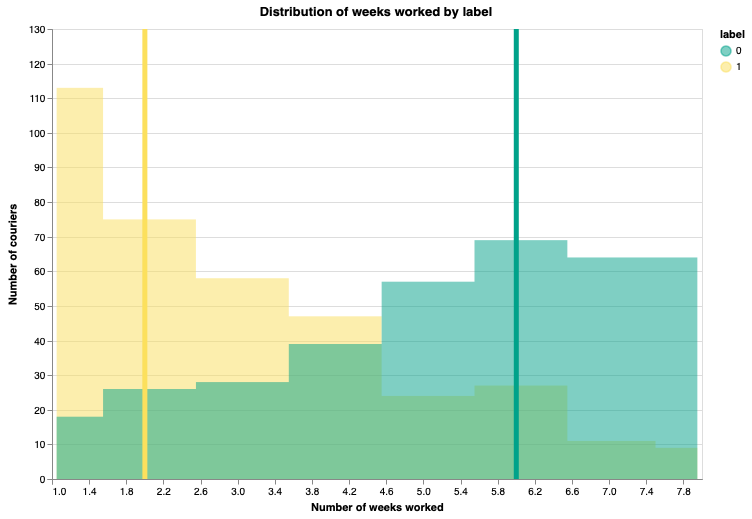

In [189]:
base = alt.Chart(weekly.groupby(['courier','label'], as_index = False).agg({'week': 'count'}))

bar = base.mark_area(
    opacity = 0.5,
    interpolate = 'step'
).encode(
    alt.X('week', title = 'Number of weeks worked', bin = alt.Bin(maxbins = 100)),
    alt.Y('count()', scale = alt.Scale(domain = (0,130)), title = 'Number of couriers', stack = None),
    alt.Color('label:N', scale = alt.Scale(range = [glovogreen, glovoyellow]))
).properties(width = 650, height = 450, title = 'Distribution of weeks worked by label')

rule = base.mark_rule().encode(
    x = alt.X('median(week):Q'),
    color = 'label:N',
    size = alt.value(5)
)

bar + rule

* The above chart shows the distribution of weeks worked by label as well their respective median value (indicated by the bar)
* Clearly, couriers churning in week 9, 10 and 11 work significantly fewer weeks prior to week 8
* Also note below that the number of couriers who will churn in week 9, 10 and 11 decreases week by week. In words, churn does not occur suddenly for all couriers. Many of them seem to churn several weeks prior to week 8.
* Both of these observations seem promising for the model later on

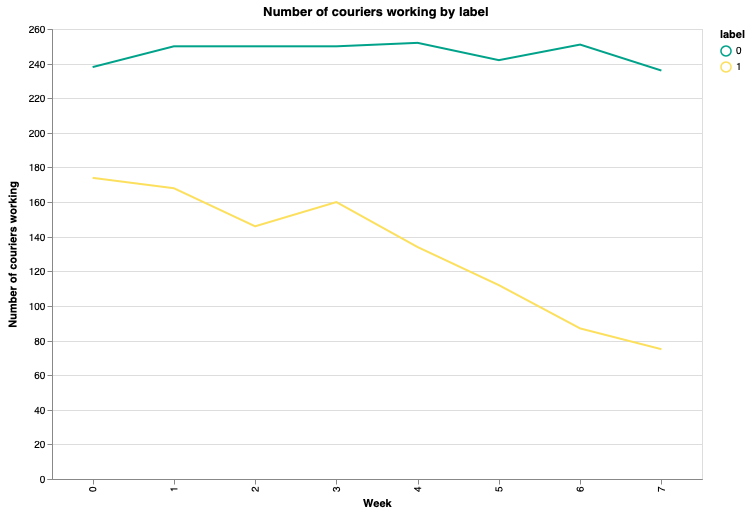

In [190]:
weekly_couriers = pd.DataFrame(weekly.groupby(['week','label']).size())
weekly_couriers.columns = ['Number of couriers']
weekly_couriers.reset_index(inplace = True, drop = False)

alt.Chart(weekly_couriers).mark_line().encode(
    alt.X('week:O', title = 'Week'),
    alt.Y('Number of couriers:Q', title = 'Number of couriers working'),
    alt.Color('label:N', scale = alt.Scale(range = [glovogreen, glovoyellow]))
).properties(width = 650, height = 450, title = 'Number of couriers working by label')

Next, we look at the distribution of features 1 to 17 as well as their median values week by week (median as many of the distributions are not normal) for the two groups of couriers. This is to explore whether some of these features are promising regarding their predictive power for churn

### Features 1 to 4

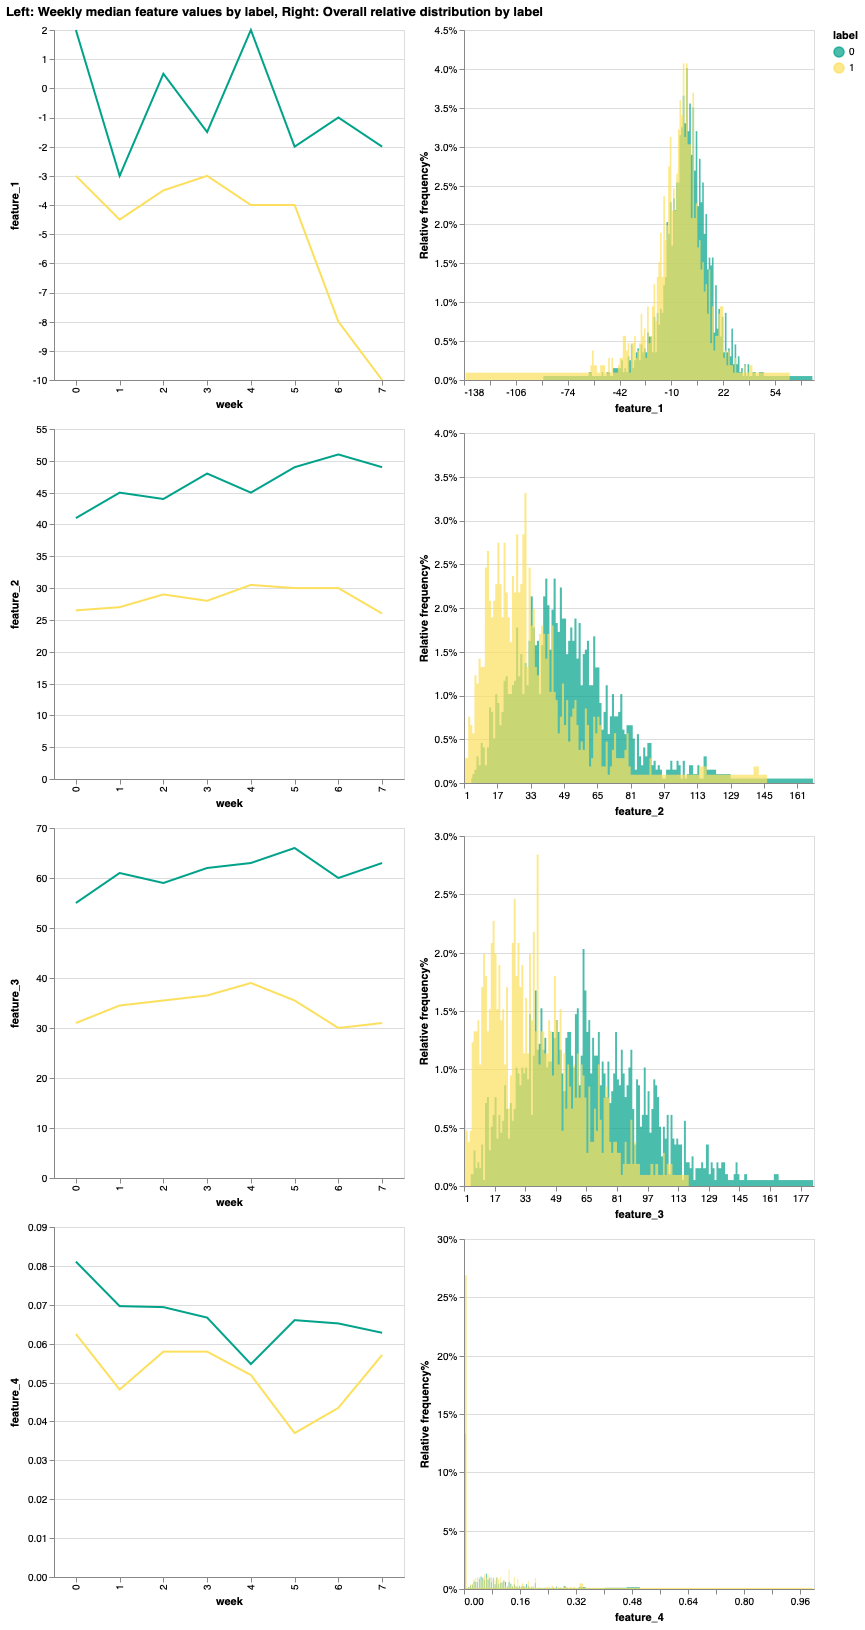

In [191]:
# Plot median feature values by week and label

features_to_plot = ['feature_1','feature_2', 'feature_3', 'feature_4']

x = alt.Chart(weekly.groupby(['week', 'label'], as_index = False).median()[['week','label'] + features_to_plot]
).mark_line().encode(
    alt.X(alt.repeat("column"), type = 'ordinal'),
    alt.Y(alt.repeat("row"), type = 'quantitative'),
    color = alt.Color('label:N', scale = alt.Scale(range = [glovogreen, glovoyellow]))
).properties(
    width = 350,
    height = 350
).repeat(
    row = features_to_plot,
    column = ['week']
)

# Plot relative frequencies of features by label, relative makes the comparison easier here as there
# are more entries for non-churners

plots = []
for feature in features_to_plot:
    plots.append(
        alt.Chart(get_perc(weekly, 'label', feature)[[feature, feature + '_rel', 'label']]).mark_area(
            opacity = 0.7,
            interpolate = 'step'
        ).encode(
            alt.X(feature + ':Q', bin = alt.Bin(maxbins = 200), title = feature),
            alt.Y(feature + '_rel:Q', title = 'Relative frequency%', axis = alt.Axis(format = '%')),
            alt.Color('label:N', scale = alt.Scale(range = [glovogreen, glovoyellow]))
        ).properties(height = 350, width = 350
        )
    )

v = alt.vconcat(plots[0],plots[1],plots[2],plots[3])
alt.hconcat(x, v).properties(title = 'Left: Weekly median feature values by label, Right: Overall relative distribution by label')

Insights:
    
* **Feature 1**: Churners tend to have lower values for this feature. In particular, the median score for churners in week 6 and 7 decreases massively. That decrease seems to be the result of some couriers with very low values in week 6 and 7. 

* **Feature 2 & 3**: From the charts above these features seem similar scale- and distribution-wise. Clearly, churners have values concentrated more on the left-hand side of the distribution. The non-churners have a stronger right skew. Potentially useful for the model later on. Presumably these two features exhibit high positive correlation. To be checked in the next step. If so, including one of them may be sufficient.

* **Feature 4**: Values of churners here seem to be below the ones of non-churners. However, looking at the distribution of values, this lower median value seems to be caused by a large fraction of churners with a value of 0. Including a binary variable for this feature: 1 if value is 0, and 0 otherwise may be useful for the model.

### Features 5 to 8

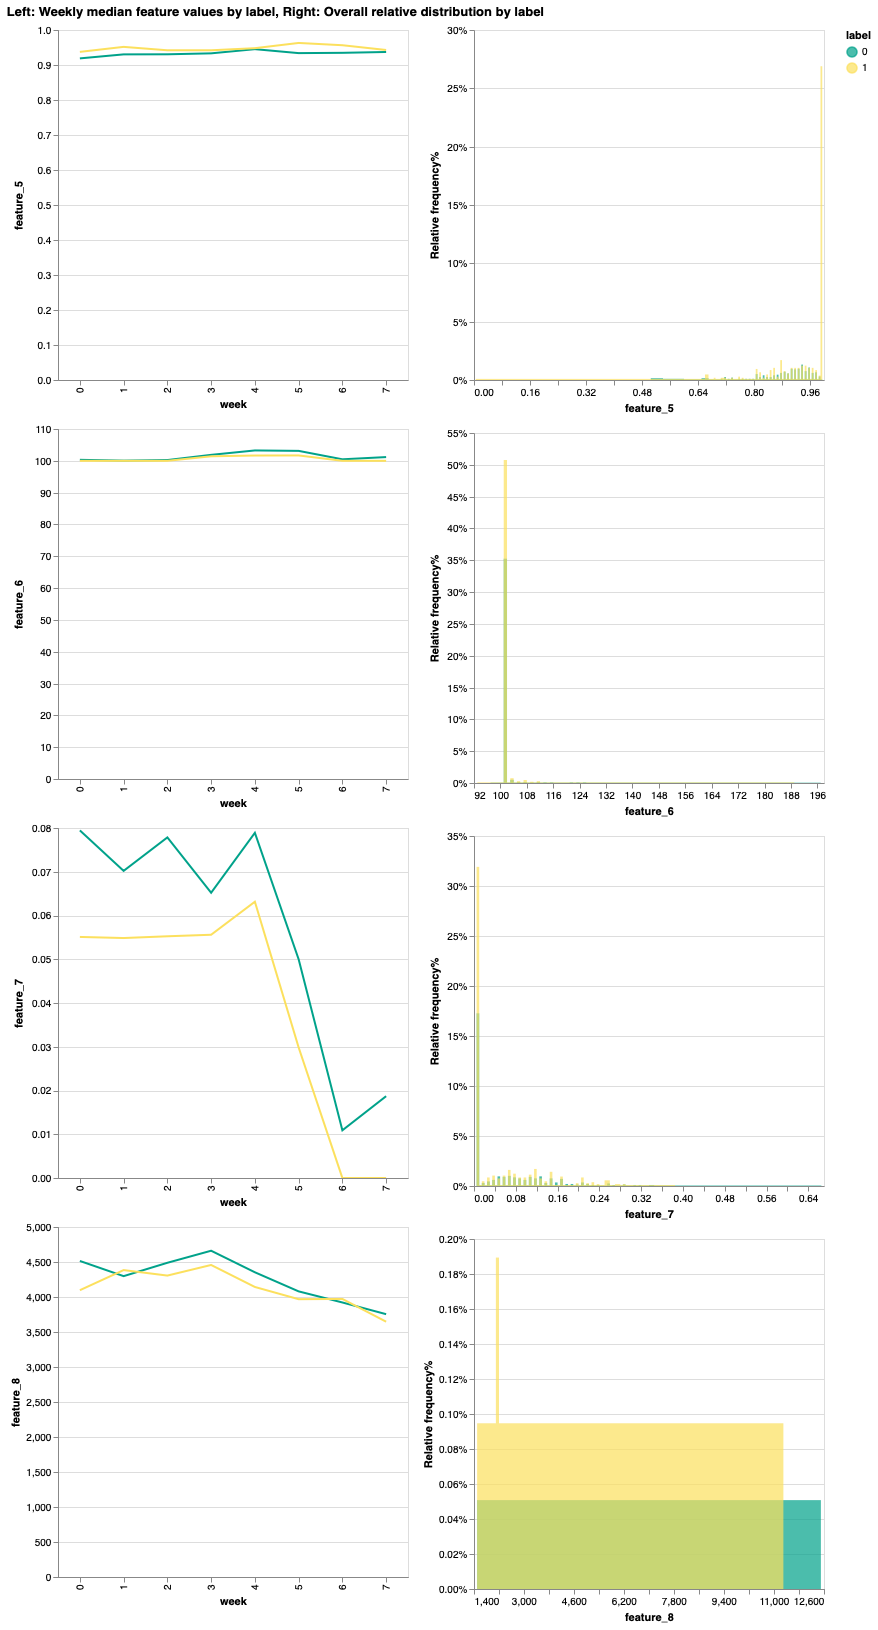

In [192]:
# Plot median feature values by week and label

features_to_plot2 = ['feature_5','feature_6', 'feature_7', 'feature_8']

x2 = alt.Chart(weekly.groupby(['week', 'label'], as_index = False).median()[['week','label'] + features_to_plot2]
).mark_line().encode(
    alt.X(alt.repeat("column"), type = 'ordinal'),
    alt.Y(alt.repeat("row"), type = 'quantitative'),
    color = alt.Color('label:N', scale = alt.Scale(range = [glovogreen, glovoyellow]))
).properties(
    width = 350,
    height = 350
).repeat(
    row = features_to_plot2,
    column = ['week']
)

# Plot relative frequencies of features by label, relative makes the comparison easier here as there
# are more entries for non-churners

plots2 = []
for feature in features_to_plot2:
    plots2.append(
        alt.Chart(get_perc(weekly, 'label', feature)[[feature, feature + '_rel', 'label']]).mark_area(
            opacity = 0.7,
            interpolate = 'step'
        ).encode(
            alt.X(feature + ':Q', bin = alt.Bin(maxbins = 100), title = feature),
            alt.Y(feature + '_rel:Q', title = 'Relative frequency%', axis = alt.Axis(format = '%')),
            alt.Color('label:N', scale = alt.Scale(range = [glovogreen, glovoyellow]))
        ).properties(height = 350, width = 350
        )
    )

v2 = alt.vconcat(plots2[0],plots2[1],plots2[2],plots2[3])
alt.hconcat(x2, v2).properties(title = 'Left: Weekly median feature values by label, Right: Overall relative distribution by label')

Insights:
    
* **Feature 5,6 & 7**: None of these features looks particularly promising in isolation. Values for these features seem to behave similarly for both groups of couriers. Moreover, most couriers have values in a very narrow range

* **Feature 8**: This feature seems to be uniformly distributed for both groups. Very high values (above 11k or so) have potentially some predictive power 

All of these features do not seem to be too relevant for churn prediction. Though we have to keep in mind this is a simple unitary analysis. Deep diving into these may change that conclusion.

### Features 9 to 12

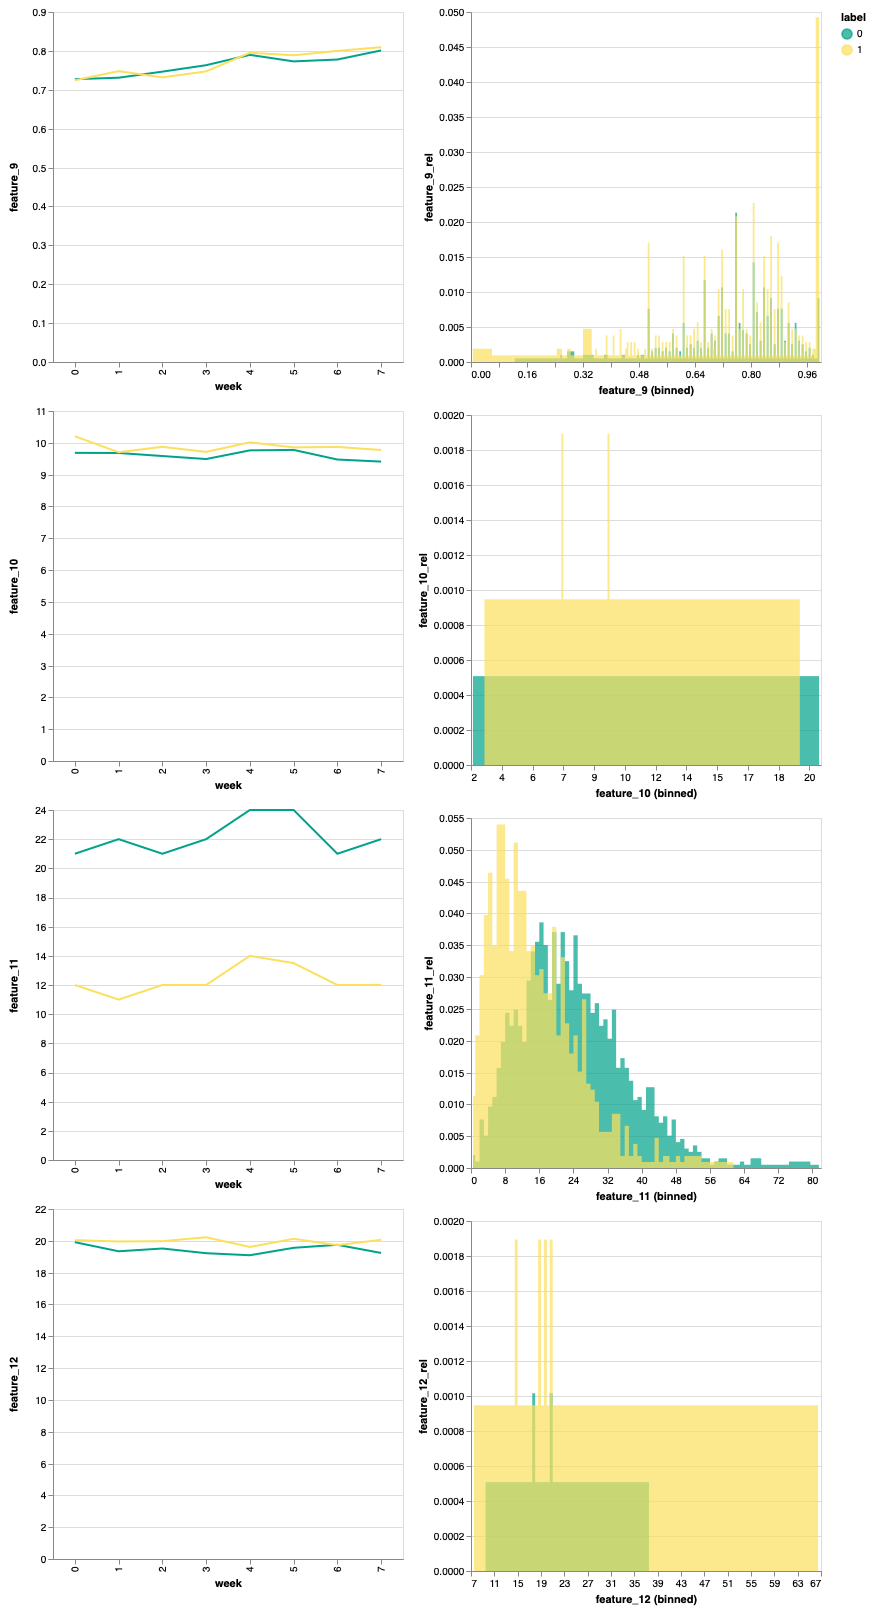

In [193]:
# Plot median feature values by week and label

features_to_plot3 = ['feature_9','feature_10', 'feature_11', 'feature_12']

x3 = alt.Chart(weekly.groupby(['week', 'label'], as_index = False).median()[['week','label'] + features_to_plot3]
).mark_line().encode(
    alt.X(alt.repeat("column"), type = 'ordinal'),
    alt.Y(alt.repeat("row"), type = 'quantitative'),
    color = alt.Color('label:N', scale = alt.Scale(range = [glovogreen, glovoyellow]))
).properties(
    width = 350,
    height = 350
).repeat(
    row = features_to_plot3,
    column = ['week']
)

# Plot relative frequencies of features by label

plots3 = []
for feature in features_to_plot3:
    plots3.append(
        alt.Chart(get_perc(weekly, 'label', feature)[[feature, feature + '_rel', 'label']]).mark_area(
            opacity = 0.7,
            interpolate = 'step'
        ).encode(
            alt.X(feature + ':Q', bin = alt.Bin(maxbins = 100)),
            alt.Y(feature + '_rel:Q'),
            alt.Color('label:N', scale = alt.Scale(range = [glovogreen, glovoyellow]))
        ).properties(height = 350, width = 350
        )
    )

v3 = alt.vconcat(plots3[0],plots3[1],plots3[2],plots3[3])
alt.hconcat(x3, v3)

Insights:
    
* **Feature 9**: The weekly median values are very close to each other and trend in the same direction. However, very high values (close to 1.0) seem to positively correlate with the probability to churn
    
* **Feature 10 + 12**: These features seem to exhibit a surprising sort-of distribution again. Deeper dive required to judge the value of these features for churn prediction.
    
* **Feature 11**: This feature seems promising as the median value for churners is significantly below the one for non-churners. Very low values seem a lot more common for churners.

### Feature 13 to 17

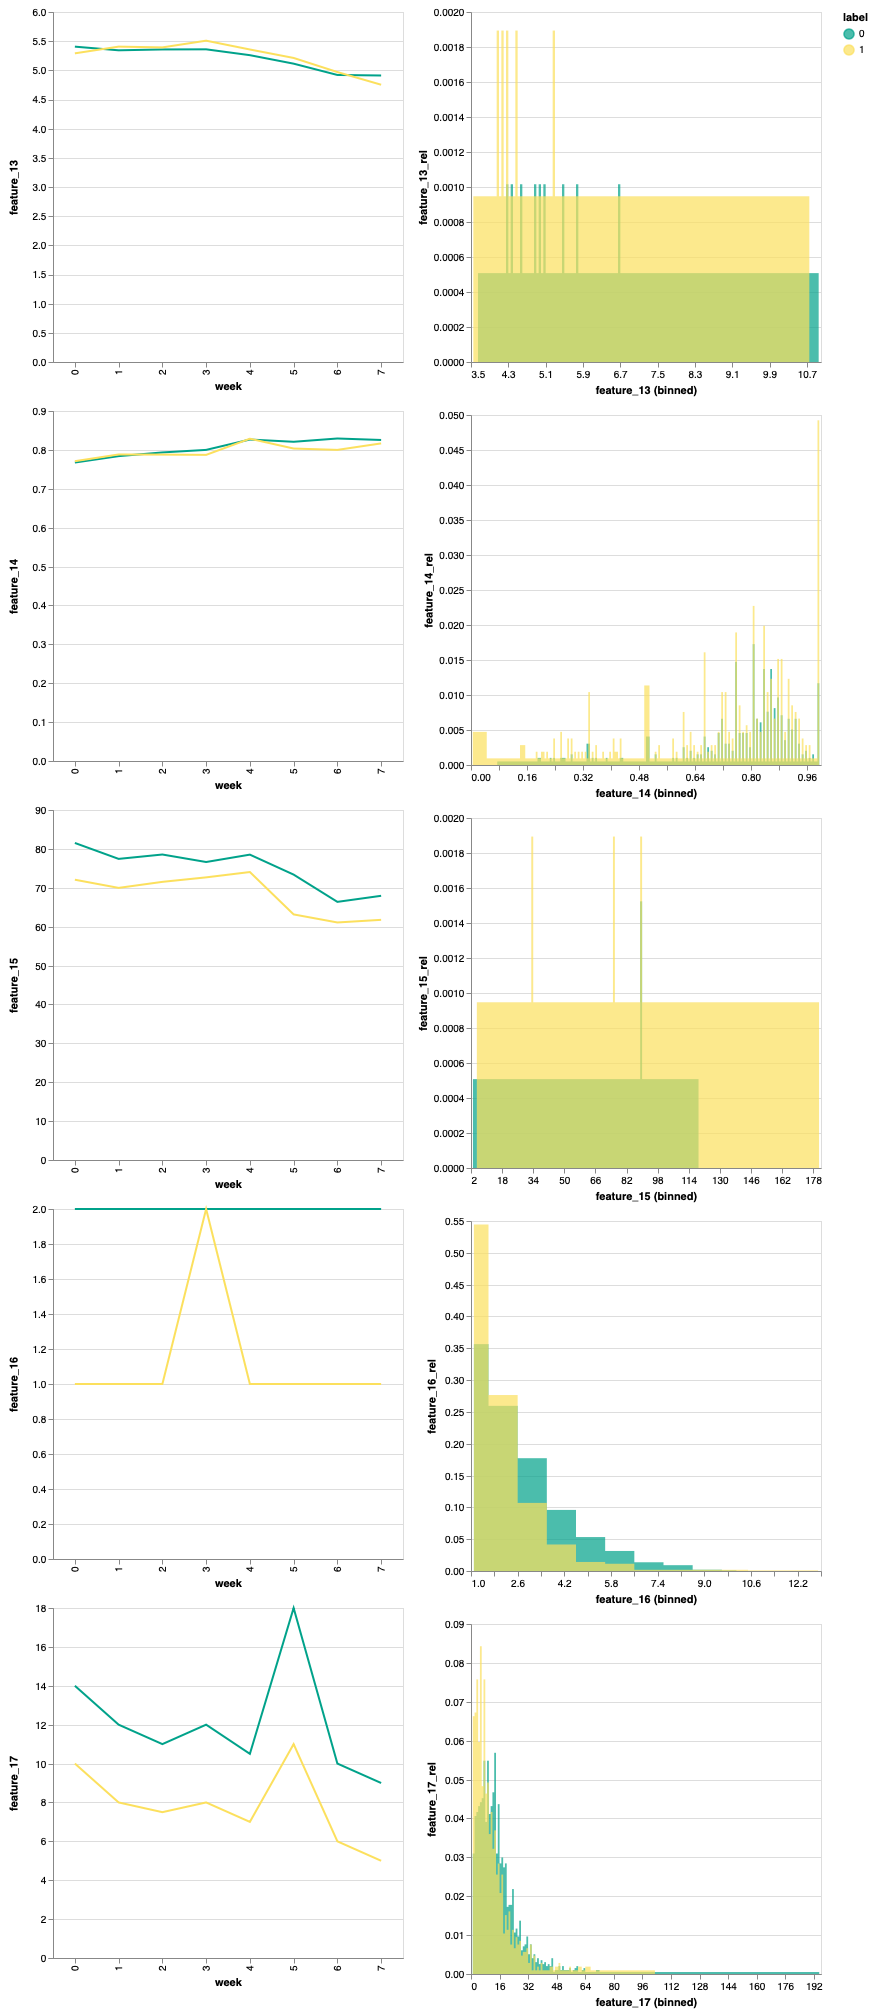

In [194]:
# Plot median feature values by week and label

features_to_plot4 = ['feature_13','feature_14', 'feature_15', 'feature_16', 'feature_17']

x4 = alt.Chart(weekly.groupby(['week', 'label'], as_index = False).median()[['week','label'] + features_to_plot4]
).mark_line().encode(
    alt.X(alt.repeat("column"), type = 'ordinal'),
    alt.Y(alt.repeat("row"), type = 'quantitative'),
    color = alt.Color('label:N', scale = alt.Scale(range = [glovogreen, glovoyellow]))
).properties(
    width = 350,
    height = 350
).repeat(
    row = features_to_plot4,
    column = ['week']
)

# Plot relative frequencies of features by label

plots4 = []
for feature in features_to_plot4:
    plots4.append(
        alt.Chart(get_perc(weekly, 'label', feature)[[feature, feature + '_rel', 'label']]).mark_area(
            opacity = 0.7,
            interpolate = 'step'
        ).encode(
            alt.X(feature + ':Q', bin = alt.Bin(maxbins = 100)),
            alt.Y(feature + '_rel:Q'),
            alt.Color('label:N', scale = alt.Scale(range = [glovogreen, glovoyellow]))
        ).properties(height = 350, width = 350
        )
    )

v4 = alt.vconcat(plots4[0],plots4[1],plots4[2],plots4[3], plots4[4])
alt.hconcat(x4, v4)

Insights:
    
* **Feature 13 + 15**: These features exhibit a weird uniform distribution again
* **Feature 14**: At first sight does not seem to be a promising feature, although very low values seem to be more common for churners.
* **Feature 16**: Lower values for churners can be observed. Weekly pattern shows spike in week 3. It seems like this pattern could be potentially exploited for modeling. However, I am unsure in case the data is real whether it is just noise or whether the data has been generated like this for this test's purpose.
* **Feature 17**: Clearly, lower median values for churners observed. Spike in week 5 for both groups. Relative increase a lot higher for non-churners thought (50% vs. 20% respectively)

We identified a few features that seem promising. Let's look at the relationship between these variables. For that we compute the correlation matrix below:

In [19]:
weekly.loc[:, [column for column in weekly.columns if 'feature' in column]].corr()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17
feature_1,1.000000,-0.184446,-0.107637,-0.031917,0.031922,0.070689,0.064166,0.002230,0.074508,0.039383,-0.076708,-0.011538,-0.014918,0.075377,0.118299,-0.080792,-0.146044
feature_2,-0.184446,1.000000,0.789734,0.204216,-0.204217,0.024098,-0.007325,0.148288,-0.151889,-0.147253,0.728876,-0.190415,0.027817,0.001587,-0.177244,0.431344,0.389612
feature_3,-0.107637,0.789734,1.000000,0.172822,-0.172824,0.076154,0.022822,0.076955,-0.083210,-0.159738,0.877003,-0.184805,-0.037864,0.061767,0.301041,0.490255,0.411608
feature_4,-0.031917,0.204216,0.172822,1.000000,-1.000000,-0.121234,0.003779,0.217479,-0.630019,-0.234667,0.062843,-0.305215,0.066944,-0.434895,0.002686,0.047584,0.144664
feature_5,0.031922,-0.204217,-0.172824,-1.000000,1.000000,0.121234,-0.003778,-0.217481,0.630022,0.234670,-0.062844,0.305213,-0.066947,0.434899,-0.002686,-0.047586,-0.144666
feature_6,0.070689,0.024098,0.076154,-0.121234,0.121234,1.000000,0.163850,-0.156730,0.188016,-0.038979,0.061189,0.019752,0.233384,0.158231,0.038158,0.022463,0.006640
feature_7,0.064166,-0.007325,0.022822,0.003779,-0.003778,0.163850,1.000000,0.113607,0.072526,-0.027542,0.004092,-0.014958,-0.032110,0.153089,0.179909,0.070922,-0.005763
feature_8,0.002230,0.148288,0.076955,0.217479,-0.217481,-0.156730,0.113607,1.000000,-0.162868,-0.105808,0.052372,0.007692,0.648861,-0.106252,0.140880,0.102029,0.064077
feature_9,0.074508,-0.151889,-0.083210,-0.630019,0.630022,0.188016,0.072526,-0.162868,1.000000,0.153079,-0.010982,0.120541,-0.284753,0.765442,0.067482,-0.046384,-0.288127
feature_10,0.039383,-0.147253,-0.159738,-0.234667,0.234670,-0.038979,-0.027542,-0.105808,0.153079,1.000000,0.170322,0.212005,-0.016074,0.073766,0.110454,-0.063476,-0.114797


Insights:
    
As previously suspected some of the provided features are related

* Feature 2 and 3 exhibit strong positive correlation (0.79)
* Feature 4 and 5 have a perfect negative correlation. In particular, feature 4 = 1 - feature 5. At most one of these features should be included in the modeling as they are completely dependent.
* Feature 3 and Feature 11 exhibit strong positive correlation (0.88). They seem to be generated by a similar gamma distribution
* The correlation of Feature 9 with Feature 4 and 5 (-0.63 and 0.63 respectively) seems suspicious and may justify a deeper dive
* There are some more positive and negative correlations to be observed which are in the range of +-0.4 to +-0.7


Finally before going into the final feature engineering and training of the model let's take a look at the lifetime features:

In [101]:
# Attach labels to lifetime table, only keep entries which have corresponding entries
# in the weekly data set
lifetime = pd.merge(lifetime, couriers, how = 'inner', left_on = 'courier', right_index = True)

In [44]:
# Compute histogram for lifetime feature 1
feat1_freq = pd.DataFrame(lifetime.groupby(['feature_1','label']).size()).reset_index(drop = False)
feat1_freq.columns = ['feature_1','label','frequency']

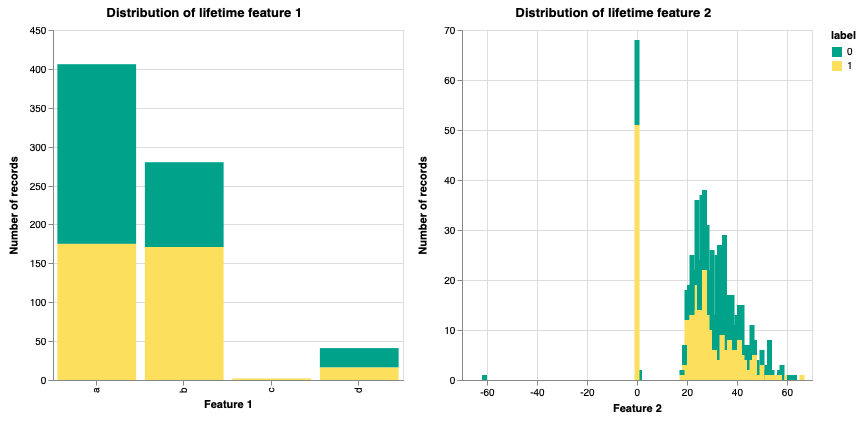

In [56]:
a = alt.Chart(feat1_freq).mark_bar().encode(
    alt.X('feature_1:N', title = 'Feature 1'),
    alt.Y('frequency:Q', title = 'Number of records'),
    alt.Color('label:N', scale = alt.Scale(range = [glovogreen, glovoyellow]))
).properties(width = 350, height = 350, title = 'Distribution of lifetime feature 1')

b = alt.Chart(lifetime).mark_bar().encode(
    alt.X('feature_2:Q', title = 'Feature 2'),
    alt.Y('count():Q', title = 'Number of records'),
    alt.Color('label:N', scale = alt.Scale(range = [glovogreen, glovoyellow]))
).properties(width = 350, height = 350, title = 'Distribution of lifetime feature 2')

alt.hconcat(a, b)

Insights

* **Feature 1**: The majority of non-churners have an 'a'. Relatively many churners have a 'b' compared to non-churners.

* **Feature 2**: A score of 0 seems to be the most common score for both groups. Values in the range of 20 to 60 seem to be more common for non-churners.

Next, let's use these insights to engineer a few features that seem like promising candidates for the model building.

Following features will be engineered:

* Number of weeks worked prior to week 8
* Binary whether entries for week 6 and 7 are present or not
* Median value of Feature 1. Potentially in a second iteration play with the fact that the median value decreases dramatically in week 6 and 7. One may include the change in those weeks compared to weeks prior (if present)
* Median value feature 3 as the distribution seems to be able to discriminate better than feature 2
* It is not clear to me whether lifetime feature 1 is of nominal or ordinal nature. Values of c and d are too rare to make any inferences. I assume, lifetime feature 1 is of nominal nature and thus I will 'One-Hot-Encode' two features for values of a and b

In [196]:
# Feature engineering for features listed above

# Attach count of weeks worked to couriers dataframe
couriers = pd.merge(couriers, 
                    weekly.groupby(['courier'], as_index = False).agg({'week': 'count'})[['courier','week']],
                    how = 'left', left_index = True, right_on = 'courier')

couriers.columns = ['label','courier','weeks_worked']

# Attach binary whether entries in week 6 and 7 are present or not
 
couriers['week67_bin'] = 0
for courier, data in weekly.groupby(['courier']):
    couriers.loc[couriers['courier'] == courier, 'week67_bin'] = (6 in list(data['week'])) and (7 in list(data['week']))

# Attach median of feature 1 and feature 3
couriers = pd.merge(couriers, 
                    weekly.groupby(['courier']).agg({'feature_1': 'median',
                                                     'feature_3': 'median'}),
                    how = 'left', left_on = 'courier', right_index = True)

couriers.columns = ['label','courier','weeks_worked','week67_bin','feat1_median','feat3_median']
# One-hot encoding for lifetime feature 1 for values of a and b
couriers = pd.merge(couriers,
                    lifetime.loc[:, ['courier','feature_1']],
                    how = 'left', on = 'courier')

couriers['lt_a'] = np.where(couriers.feature_1 == 'a', 1, 0)
couriers['lt_b'] = np.where(couriers.feature_1 == 'b', 1, 0)

The data set is pretty much balanced as shown below. This means, the baseline that the model has to beat at the very least to be of any use is 50%.

In [134]:
couriers.label.value_counts()[0] / (couriers.label.value_counts()[0] + couriers.label.value_counts()[1])

0.5006858710562414

Here we will use an exhaustive grid search over the given parameter space. The reason for using this approach
is that the number of meaningful parameters is relatively small, the data set is relatively small, and thus it does not take
large amounts of time to perform an exhaustive search.

We perform the search in two stages, as for the case of our logistic regression estimator not all parameter combinations are valid.

We use cross validation with 4 splits in order to avoid overfitting and get a sense of the variation of the final results.

Finally we choose the best hyperparameter settings as returned by the Grid Search, and evaluate the final model using those hyperparameters with a confusion matrix

In [197]:
labels = couriers.loc[:,'label']
training = couriers.loc[:,['weeks_worked','week67_bin','feat1_median','feat3_median','lt_a','lt_b']]

p_grid1 = {
          "C": [1, 10, 100, 1000],
          "penalty": ['l1','l2'],
          "fit_intercept": [True, False],
          "solver": ['liblinear','saga'],
          "multi_class": ['auto']
         }

p_grid2 = {
           "C": [1, 10, 100, 1000],
           "penalty": ['l2'],
           "fit_intercept": [True, False],
           "solver": ['newton-cg','sag'],
           "multi_class": ['auto']
          }

lr = LogisticRegression(random_state = 69, max_iter = 10000)
cv = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 69)

for grid in [p_grid1, p_grid2]:
    clf = GridSearchCV(estimator = lr, param_grid = grid, cv = cv, error_score = 0.0)
    clf.fit(training, labels)
    
    scores = cross_val_score(clf, X = training, y = labels, cv = cv)
    print('These are the scores achieved: ', scores)
    print('Average score: ', scores.mean())
    print('Winning parameters: ', clf.best_params_)

These are the scores achieved:  [0.72131148 0.76923077 0.74175824 0.76373626]
Average score:  0.7490091875337777
Winning parameters:  {'C': 1, 'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l1', 'solver': 'saga'}
These are the scores achieved:  [0.72131148 0.76923077 0.73076923 0.76923077]
Average score:  0.7476355611601513
Winning parameters:  {'C': 10, 'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'newton-cg'}


The differences do not seem to be huge. Next we train the model using the winning parameters of the first iteration:
{'C': 1, 'fit_intercept': True, 'multi_class': 'auto', 'penalty': 'l1', 'solver': 'saga'}

In [198]:
lr = LogisticRegression(random_state = 69, max_iter = 10000, C = 10, fit_intercept = True, 
                        multi_class = 'auto', penalty = 'l2', solver = 'newton-cg')

lr.fit(training, labels)
scores = cross_val_score(lr, training, labels, cv = 4)

In [199]:
scores.mean()

0.7503978262174984

In [200]:
pred = lr.predict(training)

In [201]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(labels, pred)
cnf_matrix

array([[273,  92],
       [ 83, 281]])